# REDES NUERONALES RECURRENTES

Implementacion con un set de señales trigonometricas.

## Funciones comunes a todas la partes

In [2]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from tqdm import tqdm # para graficar la barra de avance
import wandb # hacer log en whights and bias




import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# key de Marcos Uriel Maillot (lelectronfou@gmail.com), cámbiela a su usario una vez finalizada la clase.
wandb.login(key="d63a15806a812590a5525d000eed0e6d6c57a023")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\CIDIEE_NN\.netrc
wandb: Currently logged in as: lelectronfou (mmaillot) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

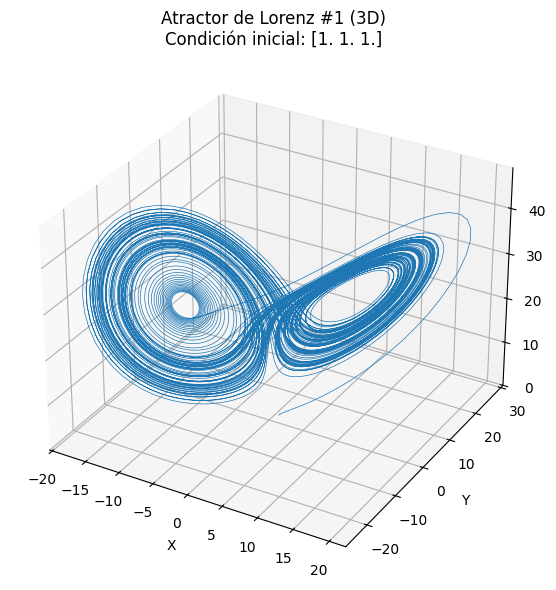

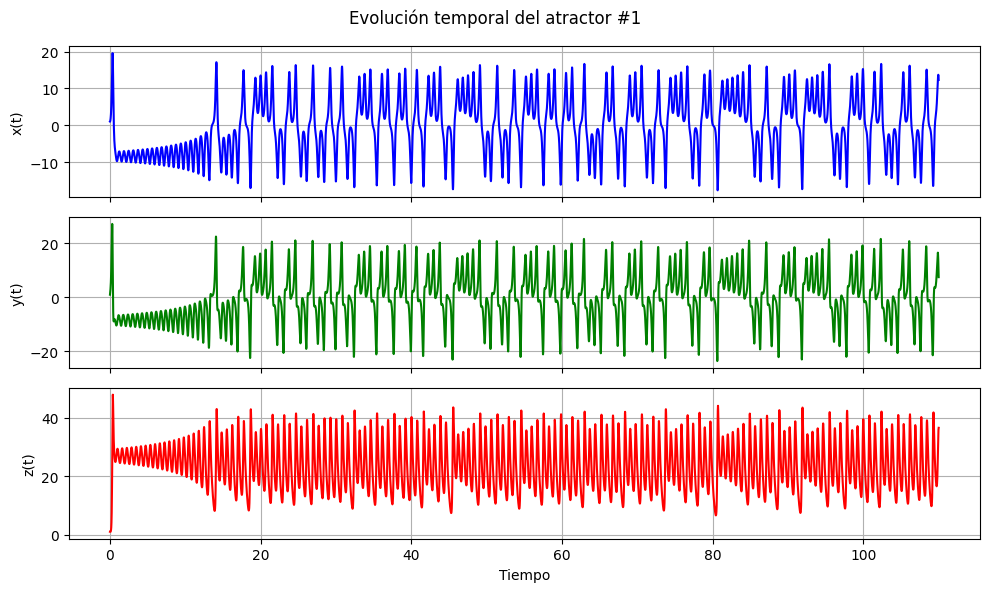

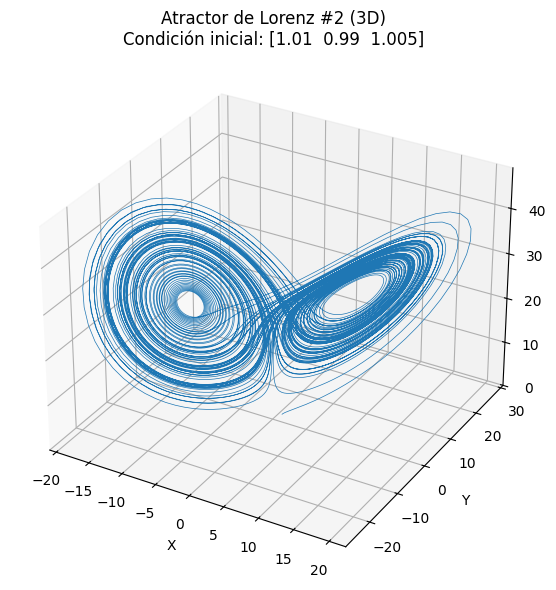

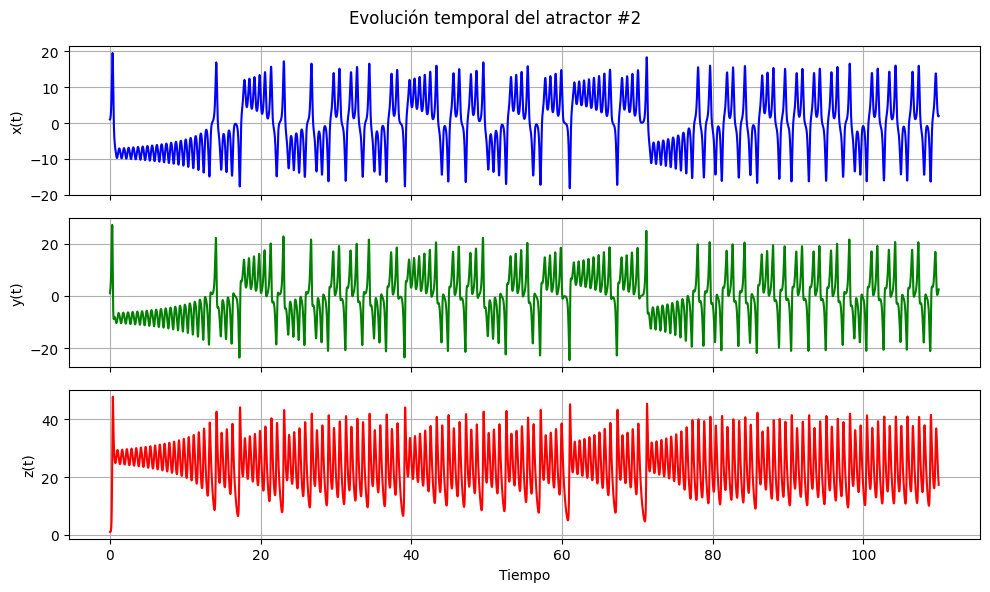

In [ ]:
# Parámetros del sistema de Lorenz
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

# Definición del sistema de ecuaciones de Lorenz
def lorenz_system(state, t, sigma, rho, beta):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return np.array([dxdt, dydt, dzdt], dtype = np.float32)

# Método de Runge-Kutta de orden 4
def rk4(f, y0, t, *args):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(1, n):
        dt = t[i] - t[i - 1]
        k1 = f(y[i - 1], t[i - 1], *args)
        k2 = f(y[i - 1] + 0.5 * dt * k1, t[i - 1] + 0.5 * dt, *args)
        k3 = f(y[i - 1] + 0.5 * dt * k2, t[i - 1] + 0.5 * dt, *args)
        k4 = f(y[i - 1] + dt * k3, t[i - 1] + dt, *args)
        y[i] = y[i - 1] + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return y.astype(np.float32)


# Tiempo de simulación
fs = 100  # Frecuencia de muestreo
t = np.arange(0, 110, 1/fs)

# Generar 2 atractores con condiciones iniciales diferentes
for i in range(2):
    # Condiciones iniciales ligeramente perturbadas
    y0 = np.array([1.0 + i*0.01, 1.0 - i*0.01, 1.0 + i*0.005])

    # Resolver el sistema
    trajectory = rk4(lorenz_system, y0, t, sigma, rho, beta)
    x, y, z = trajectory.T

    # Figura 3D
    fig3d = plt.figure(figsize=(10, 6))
    ax = fig3d.add_subplot(111, projection='3d')
    ax.plot(x, y, z, lw=0.5)
    ax.set_title(f"Atractor de Lorenz #{i+1} (3D)\nCondición inicial: {y0}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.tight_layout()

    # Figura con subplots temporales
    fig_time, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
    axs[0].plot(t, x, color='blue')
    axs[0].set_ylabel("x(t)")
    axs[0].grid(True)

    axs[1].plot(t, y, color='green')
    axs[1].set_ylabel("y(t)")
    axs[1].grid(True)

    axs[2].plot(t, z, color='red')
    axs[2].set_ylabel("z(t)")
    axs[2].set_xlabel("Tiempo")
    axs[2].grid(True)

    fig_time.suptitle(f"Evolución temporal del atractor #{i+1}")
    plt.tight_layout()

plt.show()

In [70]:
# Funcion para generar base de datos de señales
def generate_time_series(batch_size, n_steps, n_future):
    # definir array de condiciones iniciales del atractor de tamaño batch_size
    y0 = (np.random.rand(batch_size, 3) * 2 - 1)*20  # valores entre -20 y 20
    series = []
    t = np.arange(0, (n_steps+n_future), 1/fs)
    # generar las series de lorentz
    for k in range(batch_size):
        trajectory = rk4(lorenz_system, y0[k], t, sigma, rho, beta)
        series.append(trajectory)
    batch = np.stack(series, axis=0)
    batch = batch[:, :n_steps+n_future, :]  # tomar solo los primeros n_steps
    return batch

In [68]:
# función que plotea un array de curvas (inputs y outputs)
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$", fs = fs):
  # si tengo profundida de mi serie temporal, me quedo solamente con la 1ra.
  series = series[:,:,0]
  y = y[:, :,0]
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=False, sharex=False, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        #plt.plot(series[ix, :], ".-")
        plt.plot(np.arange(len(series[ix, :]))*1/fs , series[ix, :], ".-")
        if y is not None:
            plt.plot(np.arange(len(series[ix, :]), len(series[ix, :])+len(y[ix]))*1/fs, y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(np.arange(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix]))*1/fs, y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(np.arange(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix]))*1/fs, y_pred[ix] + y_pred_std[ix])
            plt.plot(np.arange(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix]))*1/fs, y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        #plt.hlines(0, 0, 100, linewidth=1)
        #plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()



In [142]:
# Clase dataset para luego armar los dataloader
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix]) # si no es train, solo devuelve el X


In [73]:
# funciones de entrenamiento
def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs+1):
        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])
        model.train()
        train_loss = []
        eval_loss = []
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            y = y.view(y.shape[0], -1) # aca elimino la dim de la profundidad
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")

        bar = tqdm(dataloader['eval'])
        model.eval()

        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y = y.view(y.shape[0], -1)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")

def predict(model, dataloader, reduced=0):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        primera = 0
        for batch in dataloader:
            X = batch
            X = X[:,-reduced:,:] # el argumento reduced toma las últimas 'reduced' muestras
            if primera == 0:
              print(  'X shape empleado para predecir: ')
              print(X.shape)
              primera = 1
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [93]:
# funciones de entrenamiento
def fit_wandb(model, optimizer, dataloader, patience = 3, patience_factor = 0.001, num_epochs=20, device = device):
    # Initialize Weights & Biases
    wandb.init(project="LORENTZ - RNN-signal", config=model.model_config(), name=model.model_config()['model_name'])

    ## Set device
    model.to(device)

    # definimos función de pérdida
    #optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    # Set metric for callbacks
    best_eval = 100
    pt_epoch = 0

    for epoch in range(num_epochs):
        ### Training Phase ###
        model.train()
        train_loss = []
        eval_loss = []


        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])

        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)


            # forward pass
            y_hat = model(X)
            y = y[:,:,0] # solo deseamos predecir la coordenada x
            y = y.view(y.shape[0], -1) # aca elimino la dim de la profundidad

            # Compute Loss
            loss = criterion(y_hat, y)

            # Zero gradients, backpropagate, and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")



        bar = tqdm(dataloader['eval'])
        model.eval()

        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y = y[:,:,0] # solo deseamos predecir la coordenada x
                y = y.view(y.shape[0], -1)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")

        # Log epoch-level metrics
        wandb.log({
            "epoch": epoch,
            "train_loss": np.mean(train_loss),
            "eval_loss": np.mean(eval_loss),
            "learning_rate": optimizer.param_groups[0]['lr'],
        })

        ## Early stopping
        if np.mean(eval_loss)<=best_eval*(1+patience_factor):
            best_eval = np.mean(eval_loss)
            pt_epoch = 0
        else:
            pt_epoch += 1
            if pt_epoch>=patience:
                print(f"Epoch {epoch+1}/{num_epochs} - Training interrupted due to early stopping condition.")
                wandb.finish()
                break
            else:
                print(f"Epoch {epoch+1}/{num_epochs} - Current epochs without validation metric improvement {pt_epoch}. {patience-pt_epoch} remaining before stopping.")
    # Finish W&B run
    wandb.finish()

def predict(model, dataloader, reduced=0):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        primera = 0
        for batch in dataloader:
            X = batch
            X = X[:,-reduced:,:] # el argumento reduced toma las últimas 'reduced' muestras
            if primera == 0:
              print(  'X shape empleado para predecir: ')
              print(X.shape)
              primera = 1
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [75]:
# función para imprimir parametros del modelo.
def imp_param(model):
  print('-'*84)
  print('PARAMETROS DEL MODELO')
  print('-'*84)
  for name, param in model.named_parameters():
    if param.requires_grad:
      print('Nombre del parámetro: ')
      print(name)
      print('Tamaño del parámetro: ')
      print(param.data.shape)
      print()
  print('-'*84)
  print('NRO TOTAL DE PARAMETROS:')
  t_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(t_params)
  print('-'*84)

## Generación de serie de datos y visualización

In [146]:
n_steps = 20
n_future = 5
sample_size = 1000
# generar index de training, validation y test
t_idx = int(sample_size * 0.7)
v_idx = int(sample_size * 0.9)

series = generate_time_series(sample_size, n_steps, n_future)
X_train, y_train = series[:t_idx, :n_steps], series[:t_idx, -n_future:]
X_valid, y_valid = series[t_idx:v_idx, :n_steps], series[t_idx:v_idx, -n_future:]
X_test, y_test = series[v_idx:, :n_steps], series[v_idx:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

X and y Train shape
(700, 20, 3) (700, 5, 3)
X and y Valid shape
(200, 20, 3) (200, 5, 3)
X and y Test shape
(100, 20, 3) (100, 5, 3)


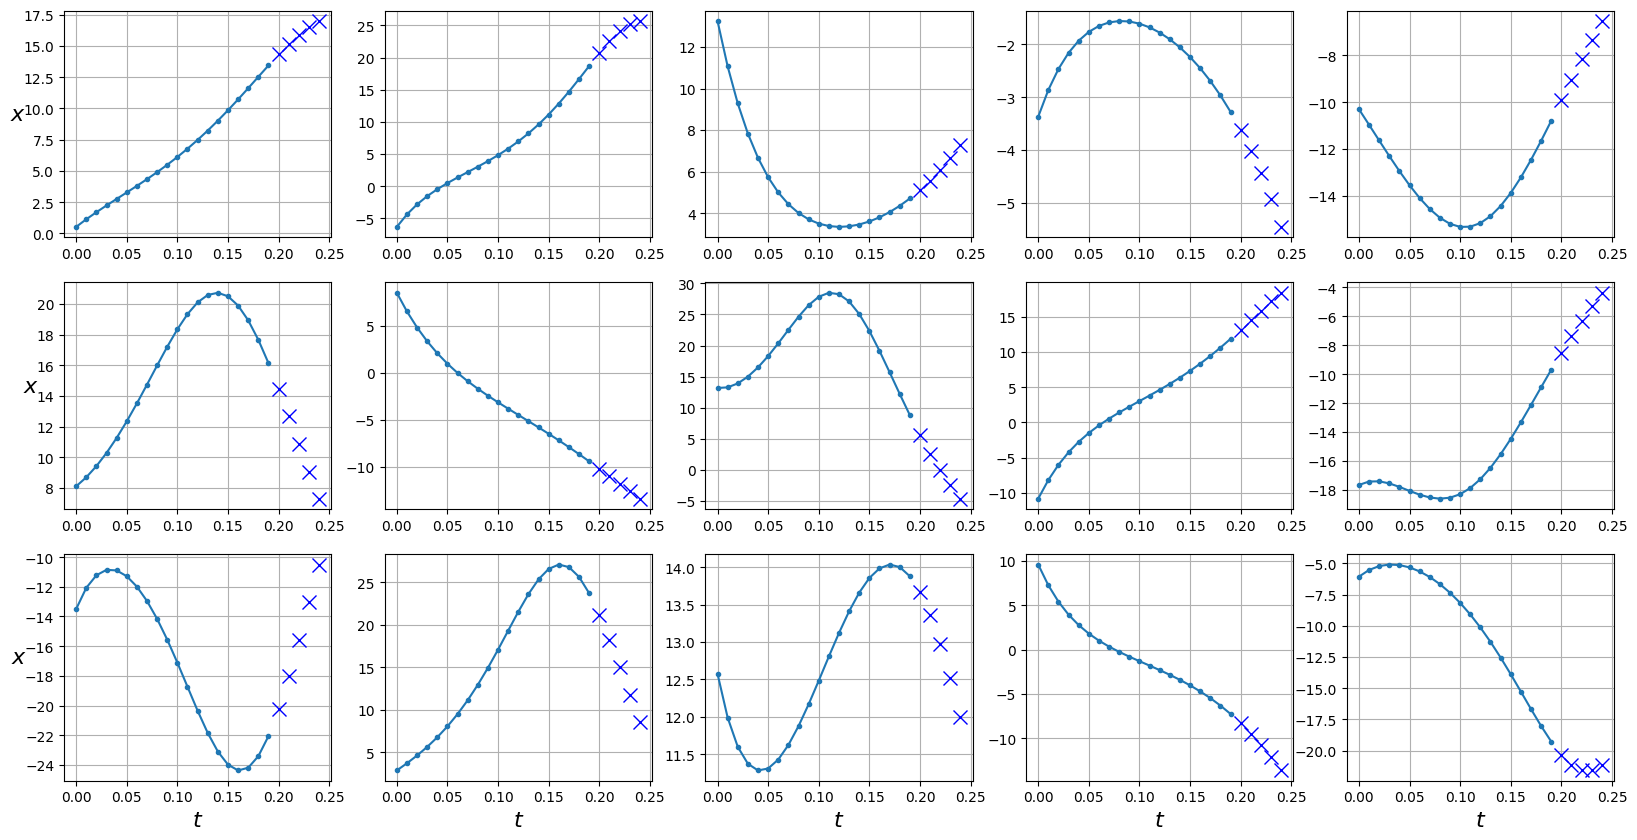

In [147]:
plot_series(X_train, y_train)

In [148]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

## MLP para comparar luego con RNN

In [161]:
class MLP(torch.nn.Module):
  def __init__(self, n_in=n_steps, n_out=n_future):
    super().__init__()
    self.fc = torch.nn.Linear(n_in*3, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def model_config(self):
    model_config = {
        "num_layers": 1,
        "num_param": sum(p.numel() for p in self.parameters() if p.requires_grad),
        "num_hidden": 1,
        "model_name": 'MLP'
    }
    return model_config



In [162]:

# n_steps y out_future definidos arriba
mlp = MLP(n_steps, n_future)
print(mlp)

model_config = dict()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
model_config["optimizer"] = optimizer.__class__.__name__
fit_wandb(mlp, optimizer, dataloader)

MLP(
  (fc): Linear(in_features=60, out_features=5, bias=True)
)


epoch numero:  0


valid_loss 203.60532: 100%|██████████| 4/4 [00:00<00:00, 318.00it/s]


Epoch 1/20 - Current epochs without validation metric improvement 1. 2 remaining before stopping.
epoch numero:  1


valid_loss 117.47975: 100%|██████████| 4/4 [00:00<00:00, 353.88it/s]


Epoch 2/20 - Current epochs without validation metric improvement 2. 1 remaining before stopping.
epoch numero:  2


valid_loss 73.51297: 100%|██████████| 4/4 [00:00<00:00, 288.50it/s]


epoch numero:  3


valid_loss 50.56343: 100%|██████████| 4/4 [00:00<00:00, 317.79it/s]


epoch numero:  4


valid_loss 38.06083: 100%|██████████| 4/4 [00:00<00:00, 381.14it/s]


epoch numero:  5


valid_loss 30.63941: 100%|██████████| 4/4 [00:00<00:00, 398.55it/s]


epoch numero:  6


valid_loss 25.79099: 100%|██████████| 4/4 [00:00<00:00, 2623.90it/s]


epoch numero:  7


valid_loss 21.47962: 100%|██████████| 4/4 [00:00<00:00, 500.26it/s]


epoch numero:  8


valid_loss 18.44814: 100%|██████████| 4/4 [00:00<00:00, 627.80it/s]


epoch numero:  9


valid_loss 16.05779: 100%|██████████| 4/4 [00:00<00:00, 639.40it/s]


epoch numero:  10


valid_loss 14.08978: 100%|██████████| 4/4 [00:00<00:00, 413.86it/s]


epoch numero:  11


valid_loss 12.53002: 100%|██████████| 4/4 [00:00<00:00, 651.19it/s]


epoch numero:  12


valid_loss 11.18954: 100%|██████████| 4/4 [00:00<00:00, 428.57it/s]


epoch numero:  13


valid_loss 10.01081: 100%|██████████| 4/4 [00:00<00:00, 715.23it/s]


epoch numero:  14


valid_loss 9.27428: 100%|██████████| 4/4 [00:00<00:00, 469.37it/s]


epoch numero:  15


valid_loss 8.40102: 100%|██████████| 4/4 [00:00<00:00, 499.53it/s]


epoch numero:  16


valid_loss 7.84496: 100%|██████████| 4/4 [00:00<00:00, 656.08it/s]


epoch numero:  17


valid_loss 7.23403: 100%|██████████| 4/4 [00:00<00:00, 716.98it/s]


epoch numero:  18


valid_loss 6.76731: 100%|██████████| 4/4 [00:00<00:00, 480.27it/s]


epoch numero:  19


valid_loss 6.39565: 100%|██████████| 4/4 [00:00<00:00, 608.29it/s]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
eval_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,19
eval_loss,6.39565
learning_rate,0.001
train_loss,5.89115


X shape empleado para predecir: 
torch.Size([64, 20, 3])
Error cuadratico medio de la estimación final: 
5.291911


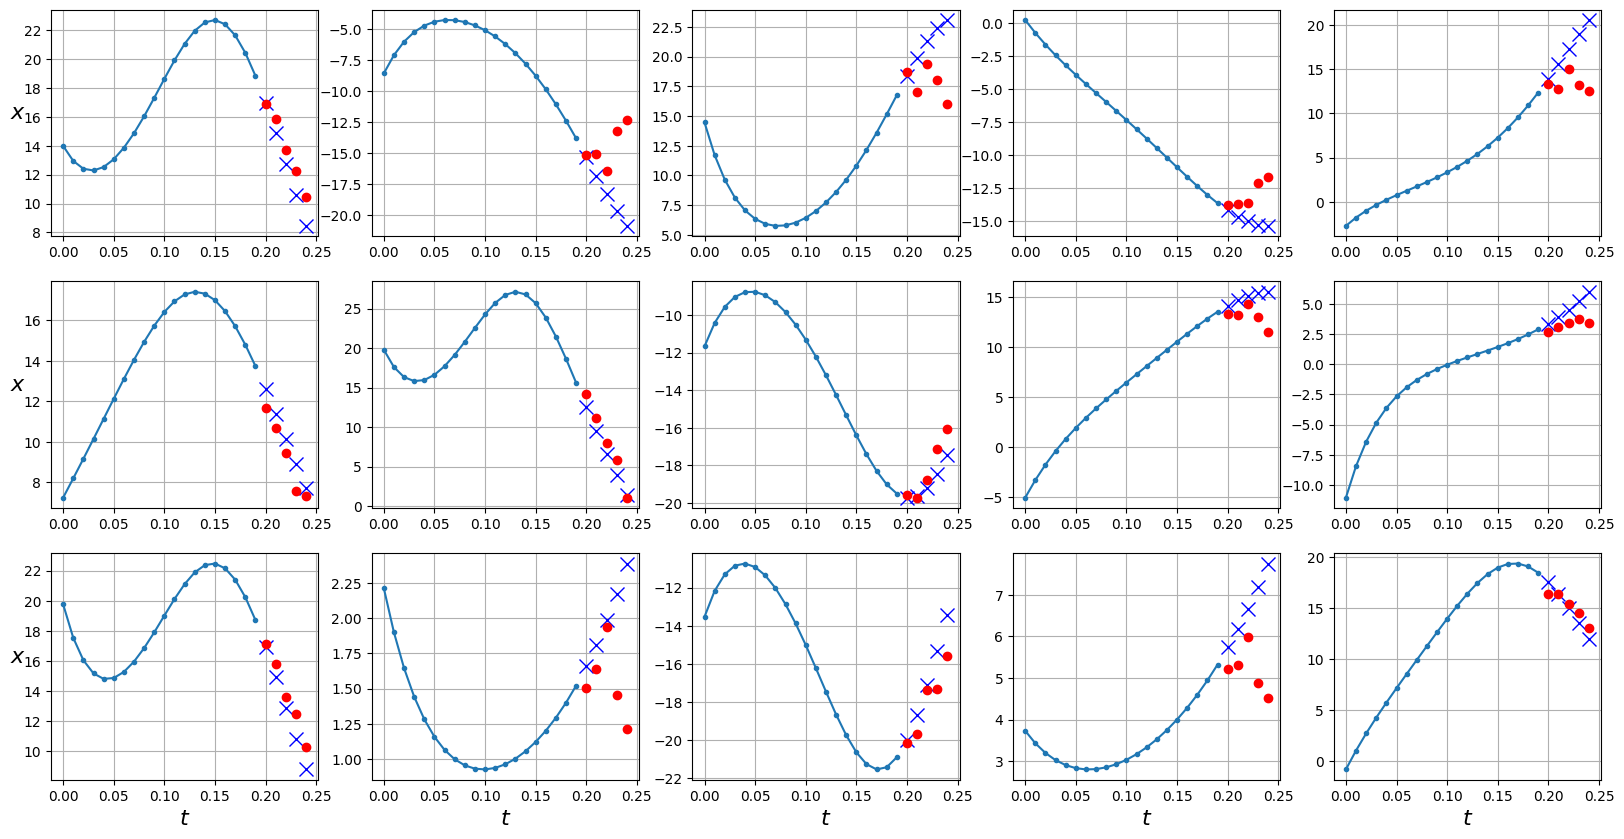

In [164]:
y_pred = predict(mlp, dataloader['test'], reduced=0)
print('Error cuadratico medio de la estimación final: ')
print(mean_squared_error(np.squeeze(y_test[:,:,0]), y_pred.cpu()))
plot_series(X_test, y_test, y_pred.cpu().numpy())


## Clase RNN para probar distintas configuraciones.

In [120]:
class RNN(torch.nn.Module):
  def __init__(self, input_size=1, hidden_size=1, num_layers=1, n_out=1, activation='tanh'):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.activation = activation
    self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers=num_layers, nonlinearity=activation, batch_first=True)
    self.fc = torch.nn.Linear(in_features=hidden_size, out_features=n_out)
    # la fc la colocamos para cuando empleemos mas de 1 neurona hidden, ya que
    # tenemos que combinar todas las hidden de la salida de RNN en 1 solo
    # valor a predecir en el futuro. Para eso usaremos las FC.
    # ver en el forward cómo se leen los valores

  def forward(self, x):
    x, h = self.rnn(x)
    # ATENCION!!
    # La salida tentrá una dimensión del [batch x largo de señal x numero de hidden]
    # y a mi FC solo quiero pasarle la última predicción temporal, de todas sus hidden.
    # por eso, me quedo con:
    #       -- todo el batch
    #       -- solo la última predición temporal
    #       -- de todas sus hidden
    x = self.fc(x[:,-1:,:]) # acá le pasamos las últimas hidden a la FC
    y = torch.squeeze(x, 1) # elimino la dimensión sobrante
    return y

  def model_config(self):
    model_config = {
        "num_layers": self.num_layers,
        "num_param": sum(p.numel() for p in self.parameters() if p.requires_grad),
        "num_hidden": self.hidden_size,
        "activation": self.activation,
        "model_name": 'RNN nh:' + str(self.hidden_size) + ' nl:' + str(self.num_layers)
    }
    return model_config



### RNN con mas capacidad (más número de neuronas hidden y/o mas capas).

Proponga nuevos modelos con un aumento en el número de neuronas hidden y/ capas y compare los resultados antes encontrados.

Estudie la cantidad de parámetros de estos nuevos modelos con los anteriores.

Estudie cómo se modifica el error de predección sobre el modelo ya entrenado, al modificar el argumento `reduced` de la función `predict`.

In [165]:
rnn_2 = RNN(input_size=3, hidden_size=20, num_layers=2,  n_out=n_future, activation='relu')
rnn_2

RNN(
  (rnn): RNN(3, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=5, bias=True)
)

In [137]:
# parámetros en el RNN

imp_param(rnn_2)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([20, 3])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.weight_ih_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.weight_hh_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 20])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

-----

In [166]:
optimizer = torch.optim.Adam(rnn_2.parameters(), lr=1e-3)
model_config["optimizer"] = optimizer.__class__.__name__

fit_wandb(rnn_2, optimizer, dataloader)

epoch numero:  0


valid_loss 171.39861: 100%|██████████| 4/4 [00:00<00:00, 258.71it/s]


Epoch 1/20 - Current epochs without validation metric improvement 1. 2 remaining before stopping.
epoch numero:  1


valid_loss 149.13214: 100%|██████████| 4/4 [00:00<00:00, 339.98it/s]


Epoch 2/20 - Current epochs without validation metric improvement 2. 1 remaining before stopping.
epoch numero:  2


valid_loss 109.65429: 100%|██████████| 4/4 [00:00<00:00, 321.37it/s]

Epoch 3/20 - Training interrupted due to early stopping condition.


epoch,▁▅█
eval_loss,█▅▁
learning_rate,▁▁▁
train_loss,█▅▁
epoch,2
eval_loss,109.65429
learning_rate,0.001
train_loss,132.02879


X shape empleado para predecir: 
torch.Size([64, 20, 3])
Error cuadratico medio de la estimación final: 
113.06384


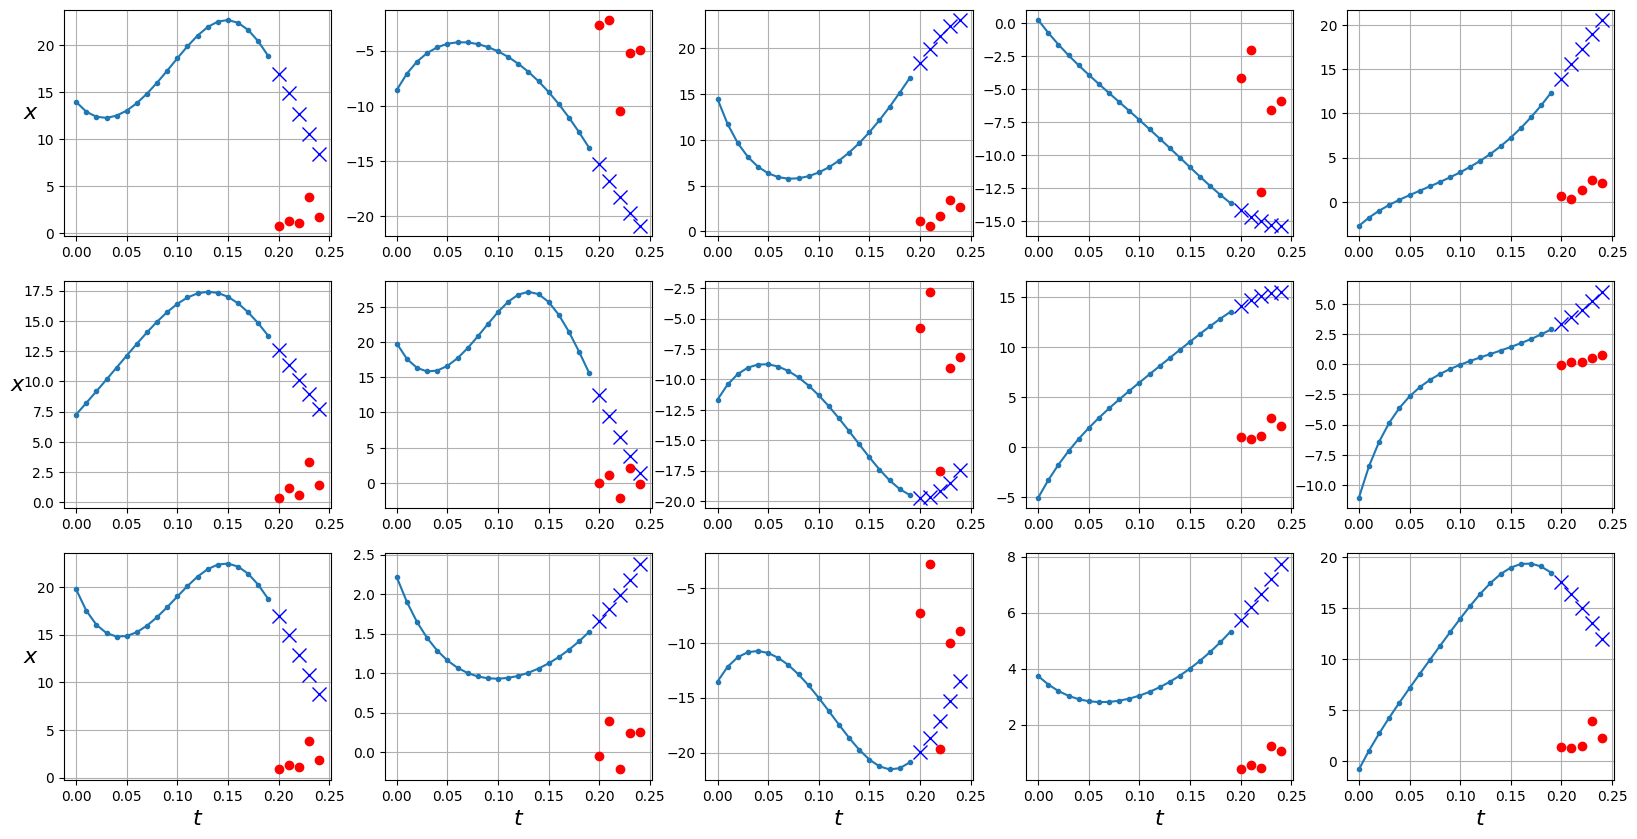

In [160]:
# la probmos con el test
y_pred = predict(rnn_2, dataloader['test'], reduced=0)

print('Error cuadratico medio de la estimación final: ')
print(mean_squared_error(np.squeeze(y_test[:,:,0]), y_pred.cpu()))
plot_series(X_test, y_test, y_pred.cpu().numpy())


### Error del  modelo en función de las muestras del pasado

X shape empleado para predecir: 
torch.Size([64, 1, 1])
X shape empleado para predecir: 
torch.Size([64, 2, 1])
X shape empleado para predecir: 
torch.Size([64, 3, 1])
X shape empleado para predecir: 
torch.Size([64, 4, 1])
X shape empleado para predecir: 
torch.Size([64, 5, 1])
X shape empleado para predecir: 
torch.Size([64, 6, 1])
X shape empleado para predecir: 
torch.Size([64, 7, 1])
X shape empleado para predecir: 
torch.Size([64, 8, 1])
X shape empleado para predecir: 
torch.Size([64, 9, 1])
X shape empleado para predecir: 
torch.Size([64, 10, 1])
X shape empleado para predecir: 
torch.Size([64, 11, 1])
X shape empleado para predecir: 
torch.Size([64, 12, 1])
X shape empleado para predecir: 
torch.Size([64, 13, 1])
X shape empleado para predecir: 
torch.Size([64, 14, 1])
X shape empleado para predecir: 
torch.Size([64, 15, 1])
X shape empleado para predecir: 
torch.Size([64, 16, 1])
X shape empleado para predecir: 
torch.Size([64, 17, 1])
X shape empleado para predecir: 
torch.S

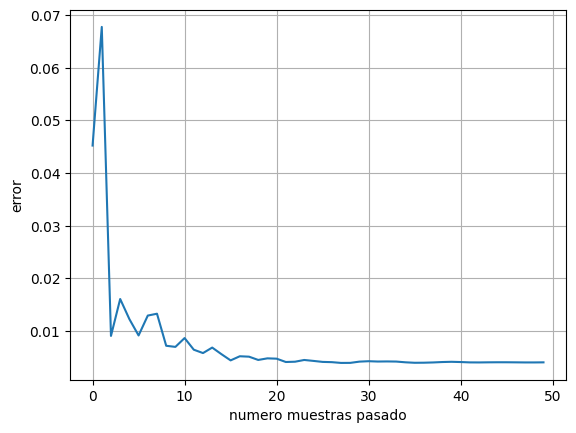

In [84]:
# preparo lista para guardar el error
err = []

# ciclo for para ir guardando el error de predicción de cada "test" hecho
for k in range(0,n_steps):
  y_pred = predict(rnn, dataloader['test'], reduced=k+1)
  err_k = mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred.cpu()))
  err.append(err_k)

# plot err vs n_steps
plt.plot(range(n_steps), err)
plt.grid(True)
plt.xlabel('numero muestras pasado')
plt.ylabel('error')
plt.show()
